# __Assignment 2 - CBD3334 - Data Mining and Analysis__

## Topic: Mobile Price prediction using phone Specifications - Regression

### __Team Members__:

- 1) Aanal Patel - C0910376
- 2) Bimal Shresta - C0919385
- 3) Danilo Diaz - C0889539
- 4) Ernie Sumoso - C0881591
- 5) Jayachandhran Saravanan - C0910392

### Importing packages

- all the required packages are imported starting from the loading the dataset in the form csv till the validation of model performance and plotting the values using visualization tools

In [1]:
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import numpy as np
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import hvplot.pandas
import plotly.express as px
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression

In [54]:
#creation of pandas dataframe and defining the read_csv function to load the data
df = read_csv(r'ndtv_data_final.csv')

In [3]:
df.head()

Unnamed: 0                            Name    Brand  \
0           0  OnePlus 7T Pro McLaren Edition  OnePlus   
1           1                   Realme X2 Pro   Realme   
2           2               iPhone 11 Pro Max    Apple   
3           3                       iPhone 11    Apple   
4           4                    LG G8X ThinQ       LG   

                    Model  Battery capacity (mAh)  Screen size (inches)  \
0  7T Pro McLaren Edition                    4085                  6.67   
1                  X2 Pro                    4000                  6.50   
2       iPhone 11 Pro Max                    3969                  6.50   
3               iPhone 11                    3110                  6.10   
4               G8X ThinQ                    4000                  6.40   

  Touchscreen  Resolution x  Resolution y  Processor  ...  Rear camera  \
0         Yes          1440          3120          8  ...         48.0   
1         Yes          1080          2400          8  ...         64.0   
2         Yes          1242          2688          6  ...         12.0   
3         Yes           828          1792          6  ...         12.0   
4         Yes          1080          2340          8  ...         12.0   

   Front camera  Operating system  Wi-Fi Bluetooth  GPS Number of SIMs   3G  \
0          16.0           Android    Yes       Yes  Yes              2  Yes   
1          16.0           Android    Yes       Yes  Yes              2  Yes   
2          12.0               iOS    Yes       Yes  Yes              2  Yes   
3          12.0               iOS    Yes       Yes  Yes              2  Yes   
4          32.0           Android    Yes       Yes  Yes              1   No   

   4G/ LTE   Price  
0      Yes   58998  
1      Yes   27999  
2      Yes  106900  
3      Yes   62900  
4       No   49990  

[5 rows x 22 columns]

### Dataset Understanding:

* Name - Name of the mobile phone 
* Brand - The Brand name of the particular mobile phone
* Model - Model name specifces the version of the particular mobile phone (eg: iphone13 has mini,pro,promax as model names)
* Battery - Defines the battey capacity in milli Amphere (hour)
* Screen size - diagnoal measurement of the screen in inches 
* Resolution x and y - are the pixel values of respective axes
* RAM - processing memory is specifiedi n MegaBytes
* Internal Storage - storage size of the phone in GigaBytes
* Rear and Front Camera - pixel capturing ability of the phone usin camera lens in MegaPixels 
* OS - The operating system of the phone 
* Number of sims - total number of sim accomodated in the phone
* processor number - total number of physical and virutal processor 
* Feature presence 
    - Bluetooh
    - WiFi
    - 3G and 4G
    - GPS
    - Touch screen
    
* Price - Target variable 

In [4]:
df.shape

(1359, 22)

In [5]:
df.drop(columns=['Unnamed: 0'], inplace=True) # Index column

In [6]:
df.shape

(1359, 21)

## Exploratory Data Analysis

In [7]:
class EDABasic:
    def __init__(self, df, numcols, catcols):
        self.df = df
        self.numcols = numcols
        self.catcols = catcols
        self.basicEDA()
        
    def basicEDA(self):
        '''
            function: basicEDA -> This function is used for the basic EDA of data frame such as shape, statstic summary
            arg: None
            return: None
        '''
        # checking the shape of the data frame
        shape = self.df.shape
        print("SHAPE OF DATAFRAME:")
        print('Columns = {}'.format(shape[0]))
        print('Rows = {}\n\n'.format(shape[1]))
        
        # cheking the missing values
        nullValues = self.df.isna().sum()
        noNull = 'No Null values' if nullValues.sum == 0 else nullValues
        print('Checking the missing values:\n')
        print('Missing values:\n{}\n\n'.format(noNull))
        
        # checking the duplicates
        duplicates = self.df.duplicated().sum()
        noduplicates = 'No Duplicat values' if duplicates == 0 else duplicates
        print('Checking the Duplicate values:')
        print('Duplicate values = {}\n\n'.format(noduplicates))
        
        # statstic summary of data frame
        print('The static summary: ')
        des = self.df.describe().T.reset_index()
        des.rename({'Index': 'Stats'}, inplace=True)
        dasData = des.to_dict(orient='list')
        table = tabulate(dasData, headers='keys', tablefmt='github', numalign='right') # tabulate converts data into table format
        print(table, '\n\n')
        
        # information of the data set
        print('The information: ')
        print(self.df.info(),'\n\n')
        
    def colPrice(self):
        '''
            function: colPrice -> shows the distribution of price in against other numaric columns in data frame using line graph
            arg: df (pandas.core.frame.DataFrame) -> data frame
            return: None
        '''
        numlist = self.numcols.columns.tolist()
        plt.figure(figsize=(5, 5))
        
        for column in range(0, len(numlist)-1, 2):
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            sns.lineplot(x=self.numcols[numlist[column]], y=self.df['Price'], data=self.numcols, ax=axes[0])
            axes[0].set_title(numlist[column])

            sns.lineplot(x=self.numcols[numlist[column + 1]], y=self.df['Price'], data=self.numcols, ax=axes[1])
            axes[1].set_title(numlist[column + 1])

            plt.show()
        
    def calculateOutlires(self):
        '''
            function: calculateOutlires -> calculates the outlires in each numarical columns using IQR method
            arg: df (pandas.core.frame.DataFrame) -> data frame
            return: None
        '''
        numlist = self.numcols.columns.tolist()
        dataList = [['Name', 'q1', 'q3', 'IQR', 'Count']]
        for column in range(len(numlist)-1):
            q1 = self.numcols[numlist[column]].quantile(0.25)
            q3 = self.numcols[numlist[column]].quantile(0.75)

            IQR = q3 - q1

            lB = q1 - 1.5 * IQR
            uB = q3 + 1.5 * IQR
            dataList.append([numlist[column],q1,q3,IQR,((self.numcols[numlist[column]] < lB) | (self.numcols[numlist[column]] > uB)).sum()])
        table = tabulate(dataList, tablefmt='pretty') # tabulate converts data into table format
        print(table)
    
    def outliresBox(self):
        '''
            function: outliresBox -> shows the distribution of outlires using box plots
            arg: df (pandas.core.frame.DataFrame) -> data frame
            return: None
        '''
        numlist = self.numcols.columns.tolist()
        for column in range(0, len(numlist)-1, 2):
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            
            sns.boxplot(self.numcols[numlist[column]], ax=axes[0])
            axes[0].set_title(numlist[column])
            
            sns.boxplot(self.numcols[numlist[column + 1]], ax=axes[1])
            axes[1].set_title(numlist[column + 1])
    
    def bollValuePlot(self, df):
        '''
            function: bollValuePlot -> shows the distribution of boolean features from the data set using pie charts
            arg: df (pandas.core.frame.DataFrame) -> data frame
            return: None
        '''
        fig, axes = plt.subplots(2, 3, figsize=(10,7))
        axes = axes.flatten()
        palettes = ['pastel', 'deep', 'bright', 'muted', 'colorblind', 'viridis']
        font_size = 15
        title_font = 20
        
        for i, (columnNmae, ax) in enumerate(zip(df.columns, axes)):
            size = df[columnNmae].value_counts()
            palette = sns.color_palette(palettes[i])
            ax.pie(size, labels=size.index, colors=palette, autopct='%1.1f%%', startangle=140, textprops={'fontsize': font_size})
            ax.set_title(columnNmae, fontsize=title_font)
            
        plt.tight_layout()
        plt.show()
        
    def FreCount(self, col, figsize_, dispercent):
        '''
            function: FreCount -> counts the percentage of catagorical columns and show the distribution using bar plots
            arg: col (pandas.core.series.Series) -> column of the data set
                 figsize_ (tuple) -> size of the graph
                 dispercent (boolean) -> 1: display the percentage of the distribution
                                         0: does not display the percentage of the distribution
            return: None
        '''
        df_brand = col.value_counts() 
        percent = round((df_brand * 100) / self.df.shape[0], 2)
        
        plt.figure(figsize=figsize_)
        ax = sns.barplot(x=percent.index, y=percent.values, palette='dark')
        plt.xlabel(col.name)
        plt.ylabel('Frequency')
        plt.xticks(rotation=90)
        if dispercent:
            for i, value in enumerate(percent):
                plt.text(i, value, str(value), ha='center', va='bottom')
        plt.show()
        
    def corr(self):
        '''
            function: corr -> Represent the correlation of each numaric column using heat map
            arg: None
            return: None
        '''
        coff = self.df.corr(method='pearson', numeric_only=True)
        plt.figure(figsize=(12,10))
        sns.heatmap(data=coff, cmap="coolwarm", annot=True, fmt=".2f", linewidths=1, linecolor='black')
        plt.show()

In [8]:
numcols = df.select_dtypes(include='number') # numeric column data set
catCols = df.select_dtypes(exclude='number') # catagorical column data set
catCols.drop(columns=['Name'], inplace=True)

C:\Users\bhair\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [9]:
numcols.head()

Battery capacity (mAh)  Screen size (inches)  Resolution x  Resolution y  \
0                    4085                  6.67          1440          3120   
1                    4000                  6.50          1080          2400   
2                    3969                  6.50          1242          2688   
3                    3110                  6.10           828          1792   
4                    4000                  6.40          1080          2340   

   Processor  RAM (MB)  Internal storage (GB)  Rear camera  Front camera  \
0          8     12000                  256.0         48.0          16.0   
1          8      6000                   64.0         64.0          16.0   
2          6      4000                   64.0         12.0          12.0   
3          6      4000                   64.0         12.0          12.0   
4          8      6000                  128.0         12.0          32.0   

   Number of SIMs   Price  
0               2   58998  
1               2   27999  
2               2  106900  
3               2   62900  
4               1   49990

In [10]:
print('BASIC EDA\n')
eda = EDABasic(df, numcols, catCols) # creating a class instance

BASIC EDA

SHAPE OF DATAFRAME:
Columns = 1359
Rows = 21


Checking the missing values:

Missing values:
Name                      0
Brand                     0
Model                     0
Battery capacity (mAh)    0
Screen size (inches)      0
Touchscreen               0
Resolution x              0
Resolution y              0
Processor                 0
RAM (MB)                  0
Internal storage (GB)     0
Rear camera               0
Front camera              0
Operating system          0
Wi-Fi                     0
Bluetooth                 0
GPS                       0
Number of SIMs            0
3G                        0
4G/ LTE                   0
Price                     0
dtype: int64


Checking the Duplicate values:
Duplicate values = No Duplicat values


The static summary: 
| index                  |   count |    mean |      std |   min |    25% |   50% |   75% |    max |
|------------------------|---------|---------|----------|-------|--------|-------|-------|--------|
|

<Figure size 500x500 with 0 Axes>

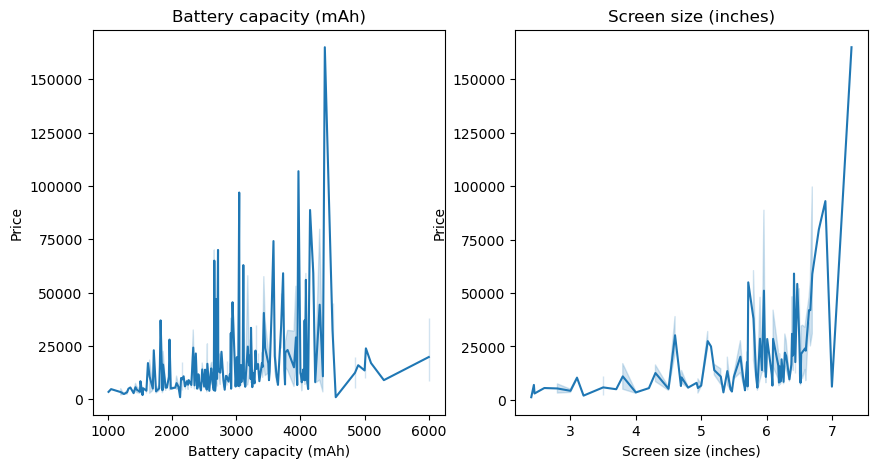

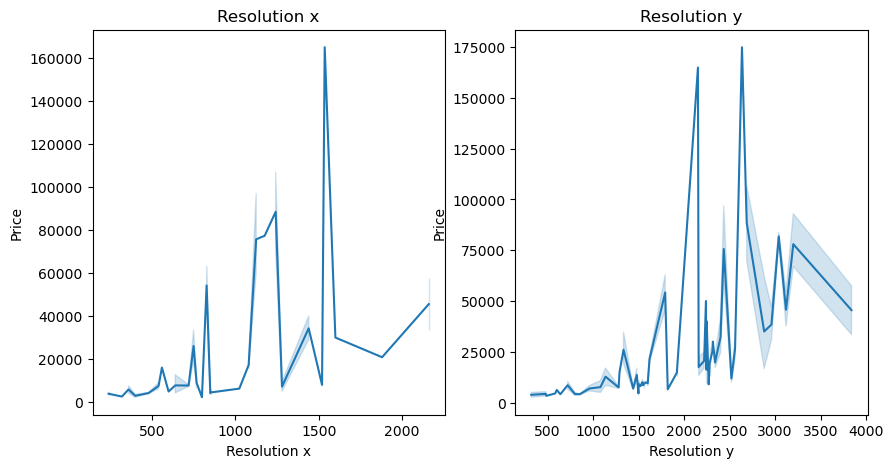

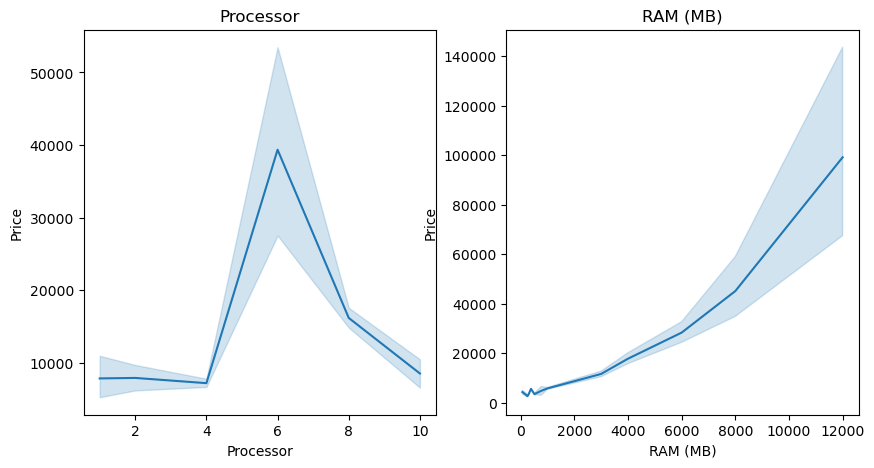

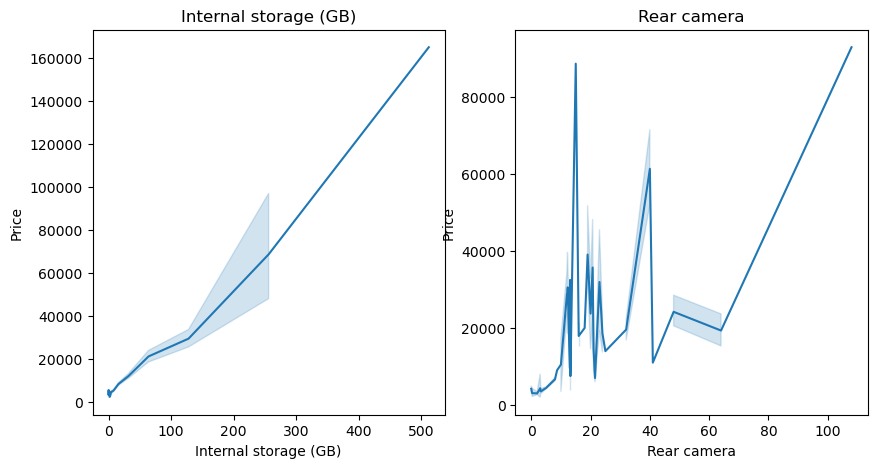

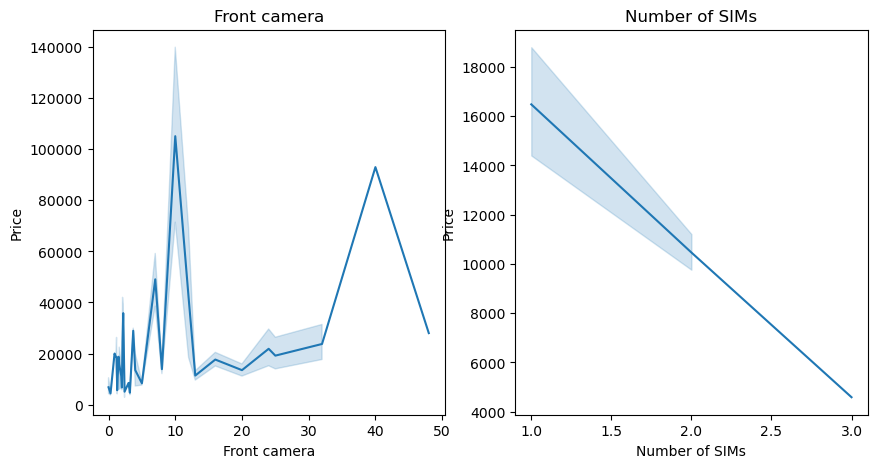

In [11]:
eda.colPrice() 

In [12]:
eda.calculateOutlires()
eda.outliresBox()

+------------------------+--------+--------+--------------------+-------+
|          Name          |   q1   |   q3   |        IQR         | Count |
| Battery capacity (mAh) | 2300.0 | 3500.0 |       1200.0       |   3   |
|  Screen size (inches)  |  5.0   |  5.7   | 0.7000000000000002 |  22   |
|      Resolution x      | 720.0  | 1080.0 |       360.0        |   3   |
|      Resolution y      | 1280.0 | 1920.0 |       640.0        |  21   |
|       Processor        |  4.0   |  8.0   |        4.0         |   0   |
|        RAM (MB)        | 1000.0 | 3000.0 |       2000.0       |  33   |
| Internal storage (GB)  |  8.0   |  32.0  |        24.0        |  79   |
|      Rear camera       |  8.0   |  13.0  |        5.0         |  91   |
|      Front camera      |  2.0   |  8.0   |        6.0         |  79   |
|     Number of SIMs     |  2.0   |  2.0   |        0.0         |  228  |
+------------------------+--------+--------+--------------------+-------+


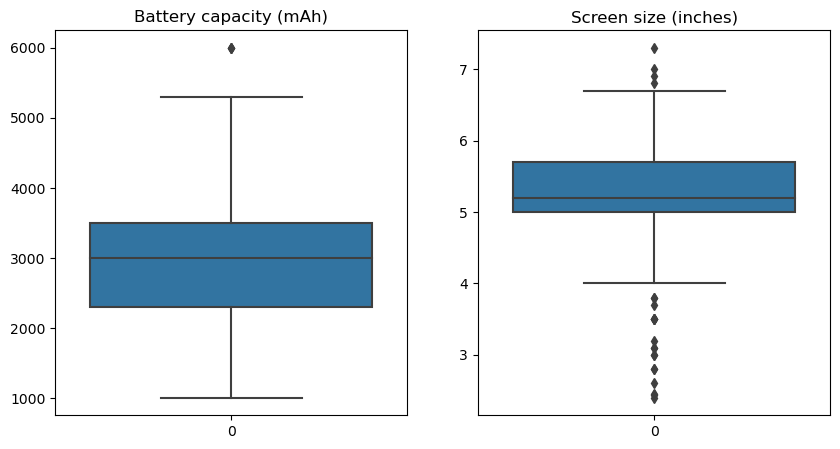

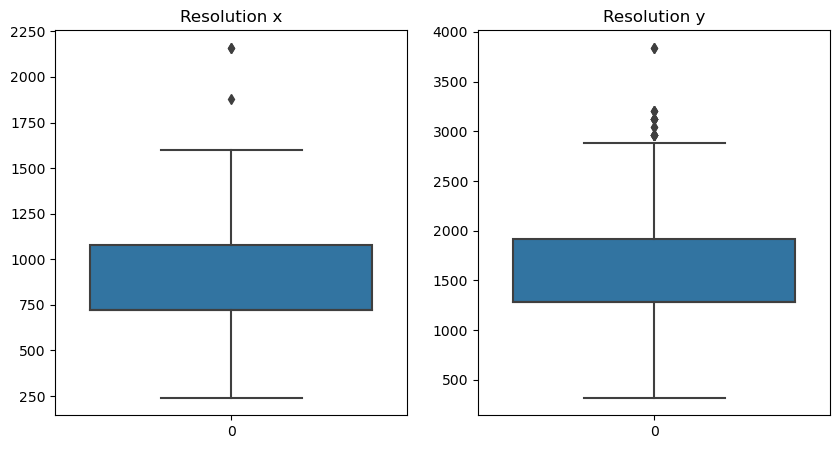

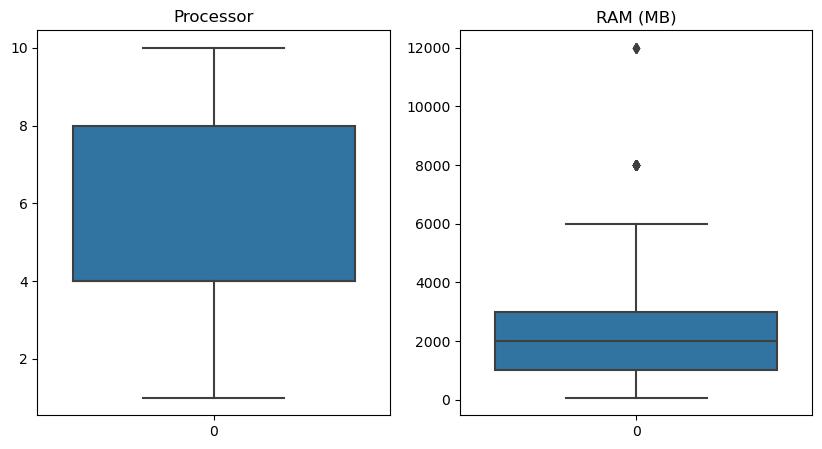

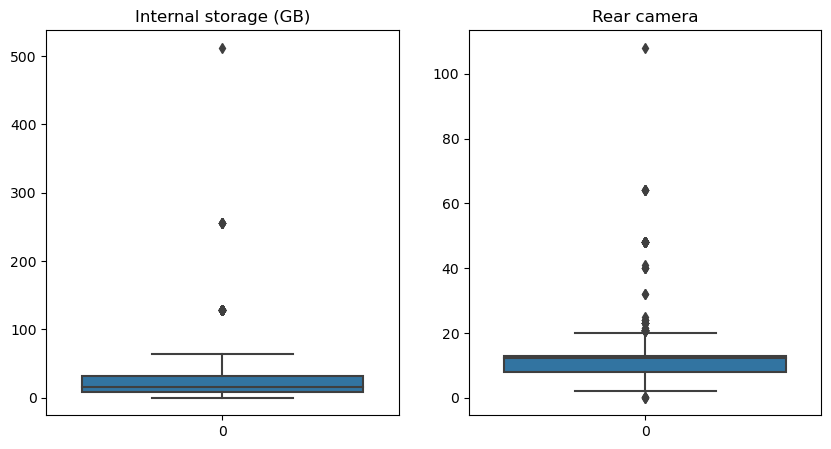

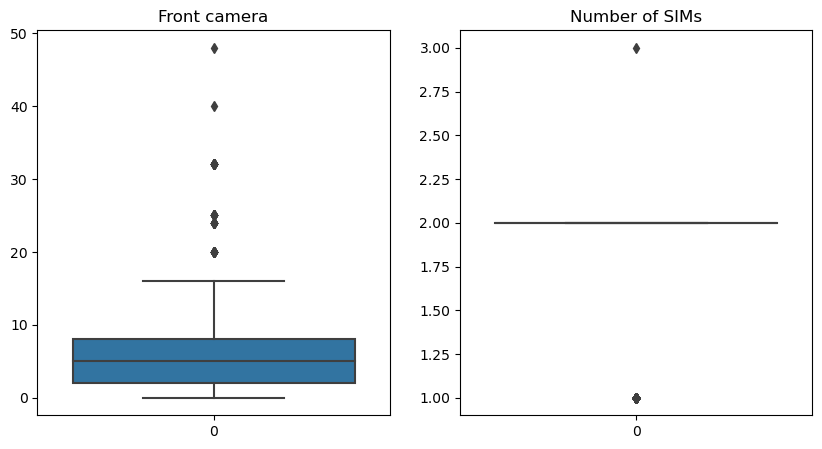

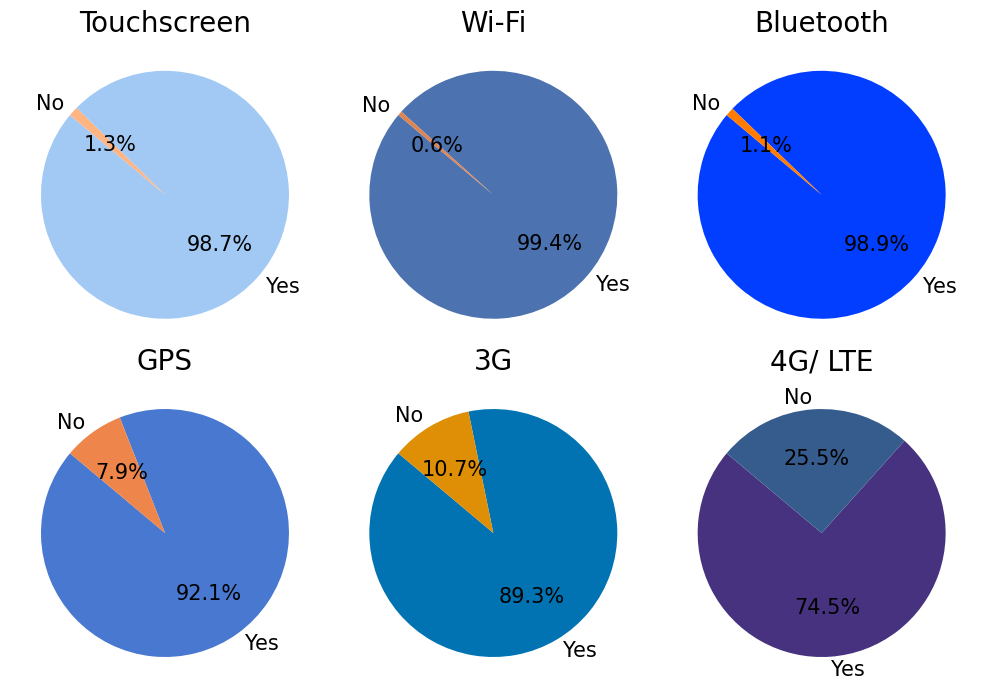

In [13]:
eda.bollValuePlot(catCols.drop(columns=['Brand', 'Model', 'Operating system']))

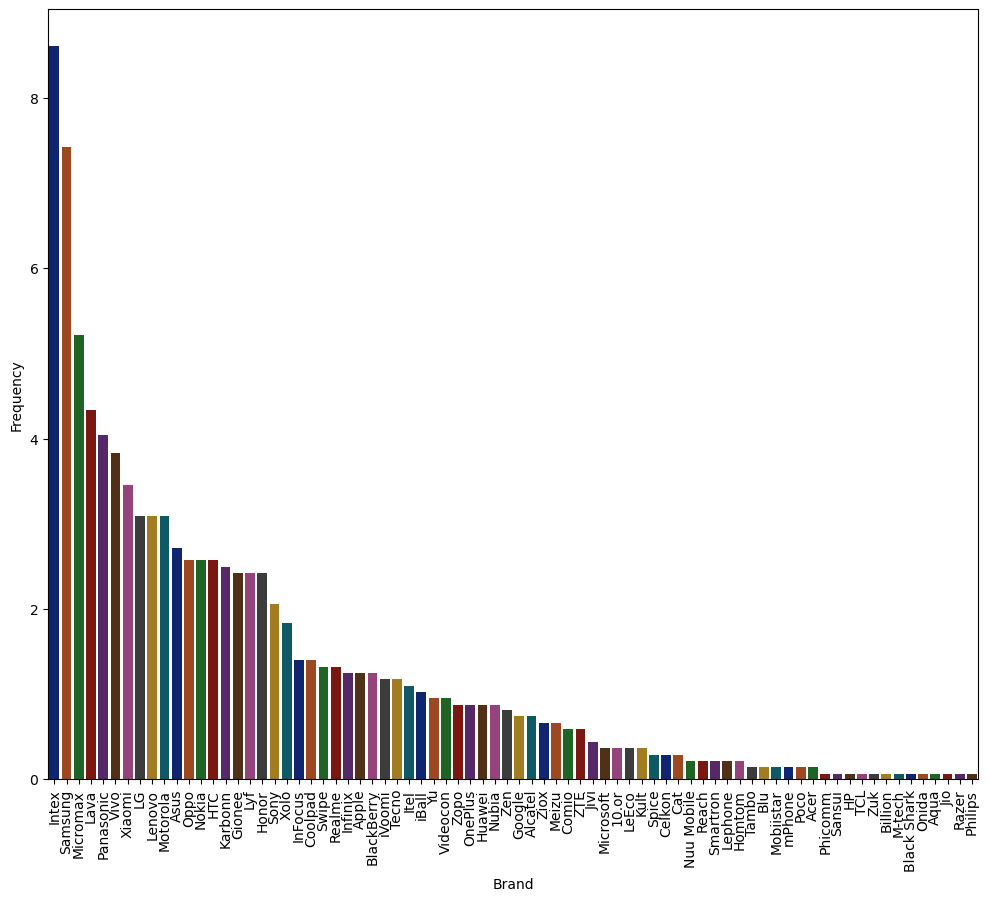

In [14]:
eda.FreCount(df['Brand'], (12, 10), 0)

In [15]:
df.head(2)

Name    Brand                   Model  \
0  OnePlus 7T Pro McLaren Edition  OnePlus  7T Pro McLaren Edition   
1                   Realme X2 Pro   Realme                  X2 Pro   

   Battery capacity (mAh)  Screen size (inches) Touchscreen  Resolution x  \
0                    4085                  6.67         Yes          1440   
1                    4000                  6.50         Yes          1080   

   Resolution y  Processor  RAM (MB)  ...  Rear camera  Front camera  \
0          3120          8     12000  ...         48.0          16.0   
1          2400          8      6000  ...         64.0          16.0   

   Operating system Wi-Fi Bluetooth  GPS Number of SIMs   3G 4G/ LTE  Price  
0           Android   Yes       Yes  Yes              2  Yes     Yes  58998  
1           Android   Yes       Yes  Yes              2  Yes     Yes  27999  

[2 rows x 21 columns]

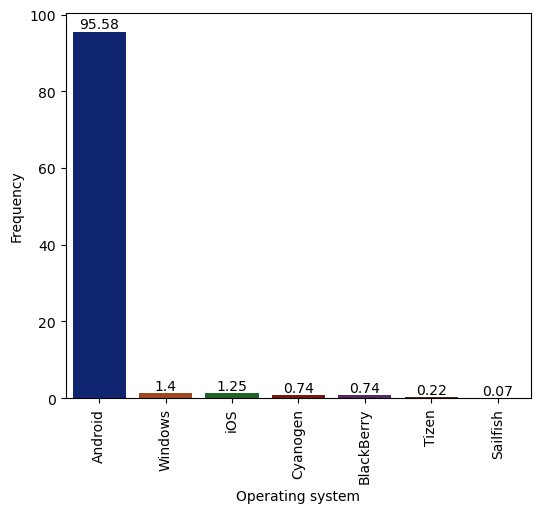

In [16]:
eda.FreCount(df['Operating system'], (6,5), 1)

In [17]:
# eda.corr()

In [18]:
df.head()

Name    Brand                   Model  \
0  OnePlus 7T Pro McLaren Edition  OnePlus  7T Pro McLaren Edition   
1                   Realme X2 Pro   Realme                  X2 Pro   
2               iPhone 11 Pro Max    Apple       iPhone 11 Pro Max   
3                       iPhone 11    Apple               iPhone 11   
4                    LG G8X ThinQ       LG               G8X ThinQ   

   Battery capacity (mAh)  Screen size (inches) Touchscreen  Resolution x  \
0                    4085                  6.67         Yes          1440   
1                    4000                  6.50         Yes          1080   
2                    3969                  6.50         Yes          1242   
3                    3110                  6.10         Yes           828   
4                    4000                  6.40         Yes          1080   

   Resolution y  Processor  RAM (MB)  ...  Rear camera  Front camera  \
0          3120          8     12000  ...         48.0          16.0   
1          2400          8      6000  ...         64.0          16.0   
2          2688          6      4000  ...         12.0          12.0   
3          1792          6      4000  ...         12.0          12.0   
4          2340          8      6000  ...         12.0          32.0   

   Operating system Wi-Fi Bluetooth  GPS Number of SIMs   3G 4G/ LTE   Price  
0           Android   Yes       Yes  Yes              2  Yes     Yes   58998  
1           Android   Yes       Yes  Yes              2  Yes     Yes   27999  
2               iOS   Yes       Yes  Yes              2  Yes     Yes  106900  
3               iOS   Yes       Yes  Yes              2  Yes     Yes   62900  
4           Android   Yes       Yes  Yes              1   No      No   49990  

[5 rows x 21 columns]

In [19]:
numeric_columns_=numcols.columns.tolist()

In [20]:
numeric_columns_

['Battery capacity (mAh)',
 'Screen size (inches)',
 'Resolution x',
 'Resolution y',
 'Processor',
 'RAM (MB)',
 'Internal storage (GB)',
 'Rear camera',
 'Front camera',
 'Number of SIMs',
 'Price']

In [21]:
categorical_columns_=catCols.columns.tolist()

In [22]:
categorical_columns_

['Brand',
 'Model',
 'Touchscreen',
 'Operating system',
 'Wi-Fi',
 'Bluetooth',
 'GPS',
 '3G',
 '4G/ LTE']

In [23]:
len(df.drop(columns='Name').columns.tolist())==len(numeric_columns_)+len(categorical_columns_)

True

## Pre-processing and feature analysis

In [24]:
class col_analyser:
    def __init__(self,data):
        """
        arg: dataframe to be processed for analysising the numeric and categorical columns

        function: class_constructor

        return: None
        """
        self.df=data
        
    def categorical_analyze(self):
        """
        arg: None

        function: detailed analysis (unique value and its count) of categorical columns present in the dataframe 

        return: dataframe describing each categorical variable characteristic --> used to transform for pre-processing 
        """
        self.categorical_columns=self.df.select_dtypes(include=['object']).columns.tolist()
        
        cat_tab=[]
        for i in self.categorical_columns:
            unique_element_counts=self.df[i].nunique()
            unique_elements=self.df[i].unique()
            cat_tab.append({'cat_column_name':i,'unique_value_counts':unique_element_counts,'unique_values':unique_elements})
        return pd.DataFrame(cat_tab)
    
    
    def numerical_analyze(self):
        """
        arg: None

        function: Visualizing the distribution and QQ plots to apply standradization on top of the numeric values before training

        return: None
        
        call: initiate the validation method 
        """
        self.numerical_columns=self.df.select_dtypes(include='number').columns.tolist()
        for i in self.numerical_columns:
            unique_element_counts=self.df[i].nunique()
            sns.set_style('darkgrid')
            fig,axs=plt.subplots(1,2,figsize=(14,6))
            sns.histplot(df[i],ax=axs[1])
            stats.probplot(df[i],plot=axs[0],fit=True)
            axs[0].set_title('QQ_plot')
            axs[1].set_title('distribution')
            fig.suptitle("numerical column analysis - {}".format(i))
            plt.tight_layout()
            plt.show()
        self.validation_()
        
      
    def validation_(self):

        """
        arg: None

        function: overall numeric and categorical columns post analysis

        return: None
        """
        print("Categorical columns are :{}".format(self.categorical_columns))
        print("numerical columns are :{}".format(self.numerical_columns))

    def correlation_with_target(self,df,target):

        """
        arg: dataframe on which correlation need to be applied
        arg: target column to calculate the correlation 

        function: correlation analysis (numeric values with respect to target variable)

        return: correlation values in descending (importance) order
        """
        return(df.corr()[target].round(3).sort_values(ascending=False))
    
    def possible_high_correlation(self,df):


        """
        arg: dataframe

        function: identifying features of high correlation

        return:  columns which are having possiblity of correlations
        """
        correlation_=df.corr()
        unique_columns_with_high_correlations=set()
        for i in range(len(correlation_.columns)):
            for j in range(i):
                if abs(correlation_.iloc[i,j])>0.6:
                    suspect_column=correlation_.columns[i]
                    unique_columns_with_high_correlations.add(suspect_column)
        return(unique_columns_with_high_correlations)
        

In [25]:
feature_analyze=col_analyser(df)

In [26]:
feature_analyze.categorical_analyze()

cat_column_name  unique_value_counts  \
0              Name                 1359   
1             Brand                   76   
2             Model                 1321   
3       Touchscreen                    2   
4  Operating system                    7   
5             Wi-Fi                    2   
6         Bluetooth                    2   
7               GPS                    2   
8                3G                    2   
9           4G/ LTE                    2   

                                       unique_values  
0  [OnePlus 7T Pro McLaren Edition, Realme X2 Pro...  
1  [OnePlus, Realme, Apple, LG, Samsung, Asus, Xi...  
2  [7T Pro McLaren Edition, X2 Pro, iPhone 11 Pro...  
3                                          [Yes, No]  
4  [Android, iOS, Cyanogen, BlackBerry, Windows, ...  
5                                          [Yes, No]  
6                                          [Yes, No]  
7                                          [Yes, No]  
8                                          [Yes, No]  
9                                          [Yes, No]

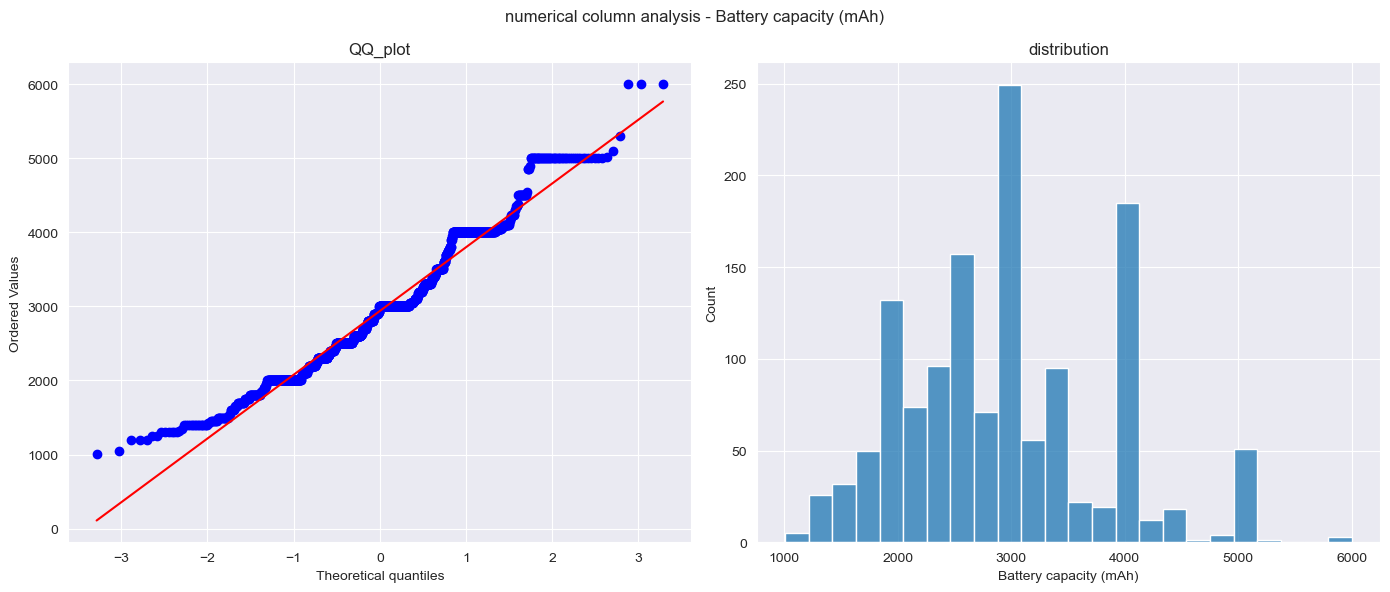

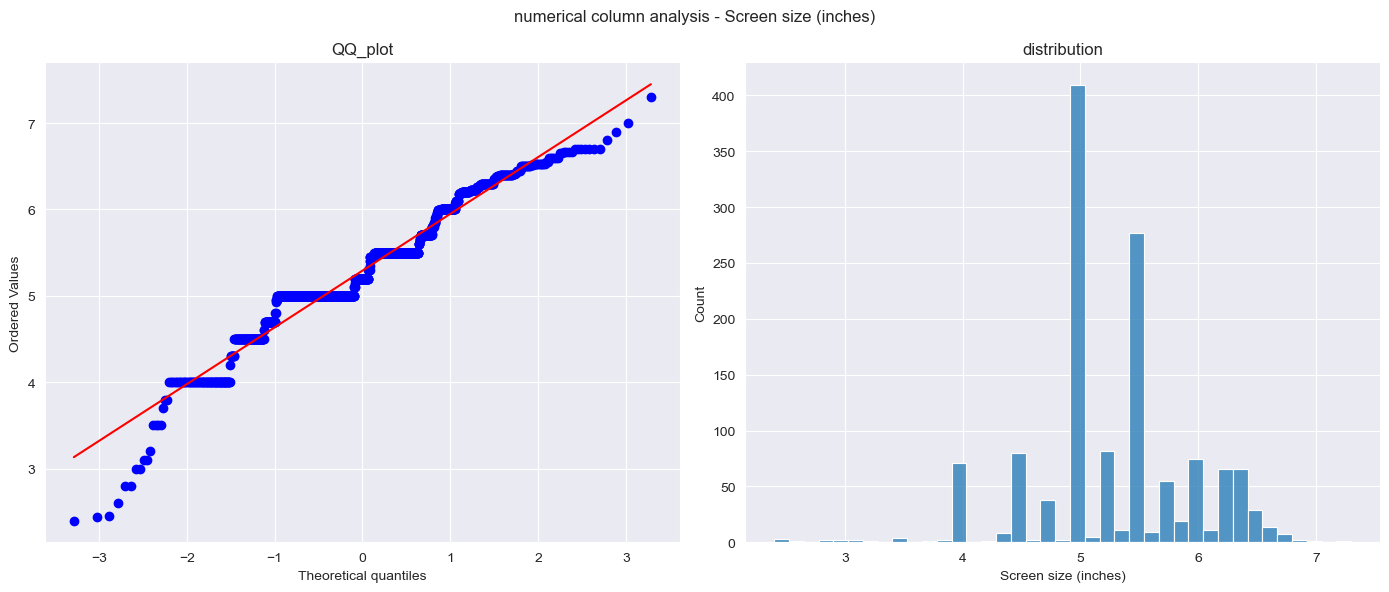

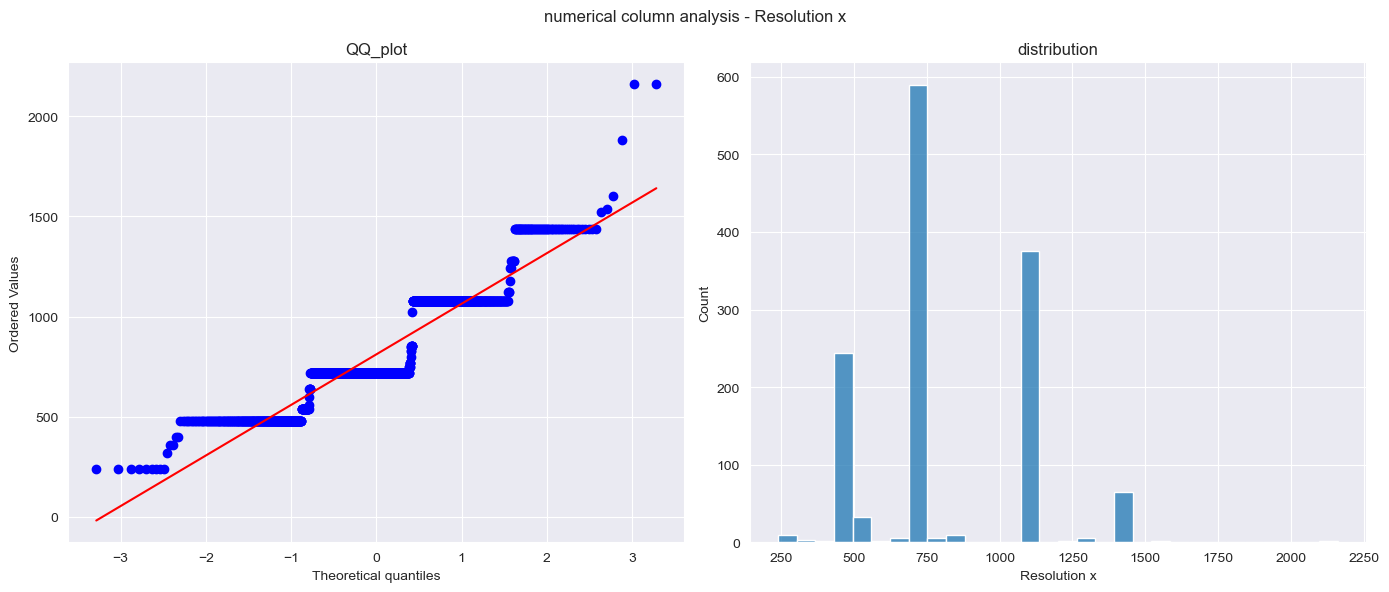

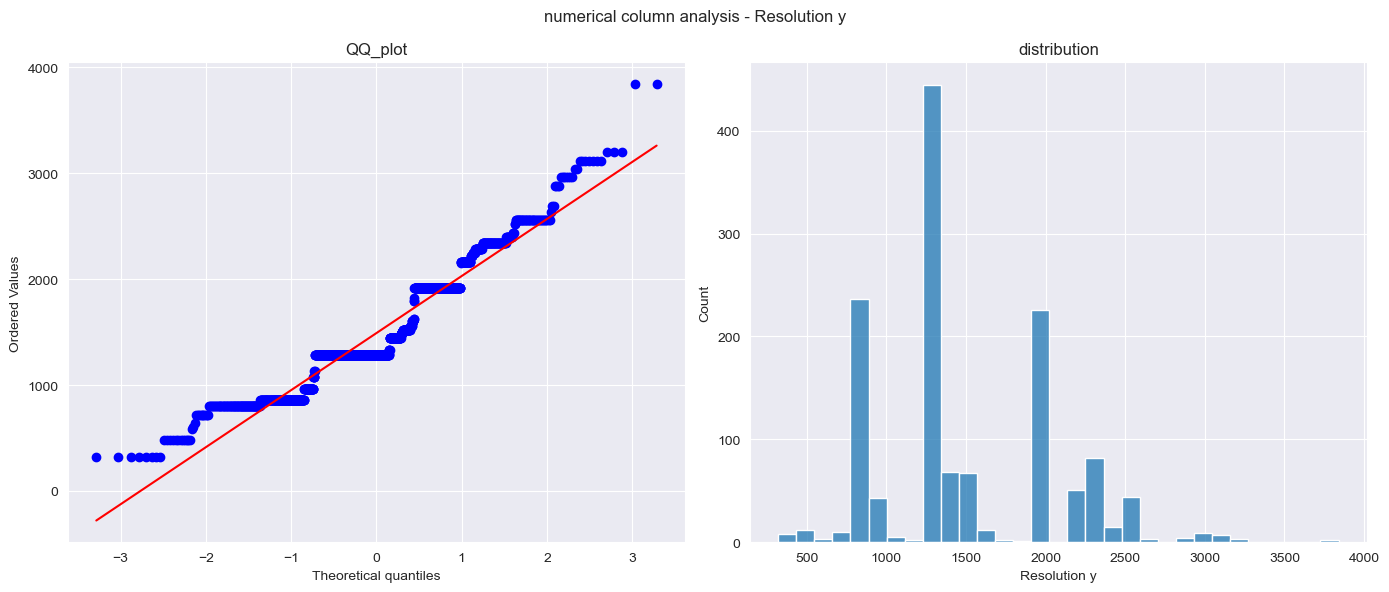

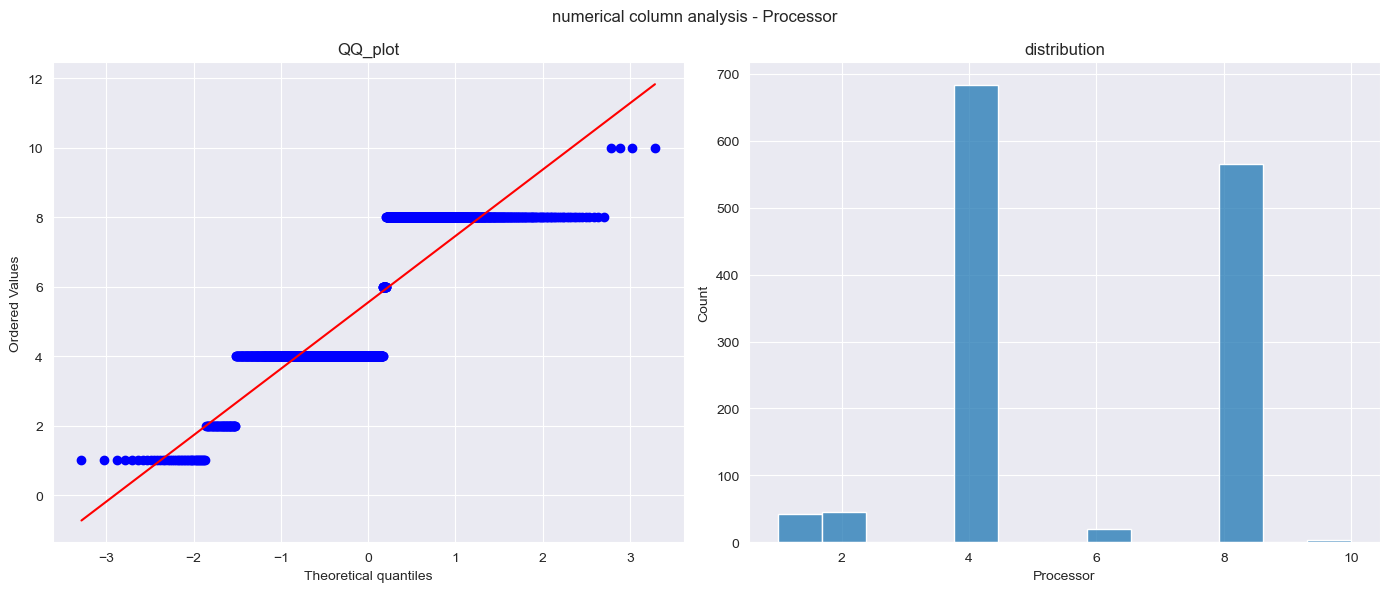

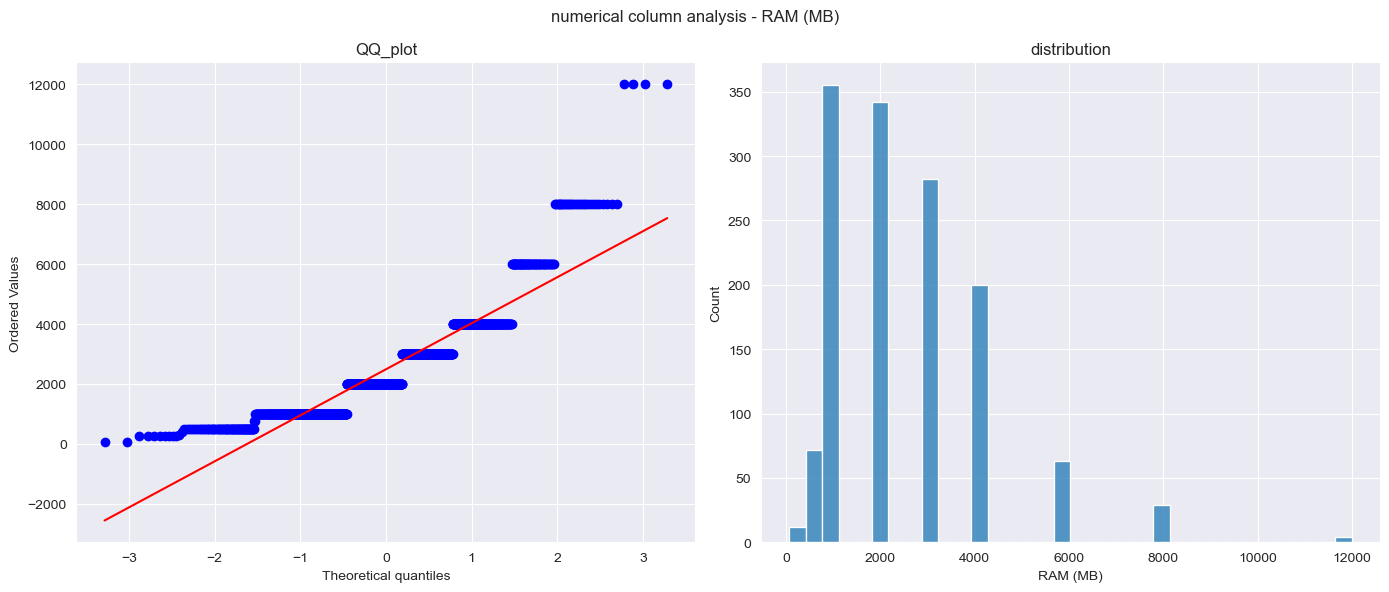

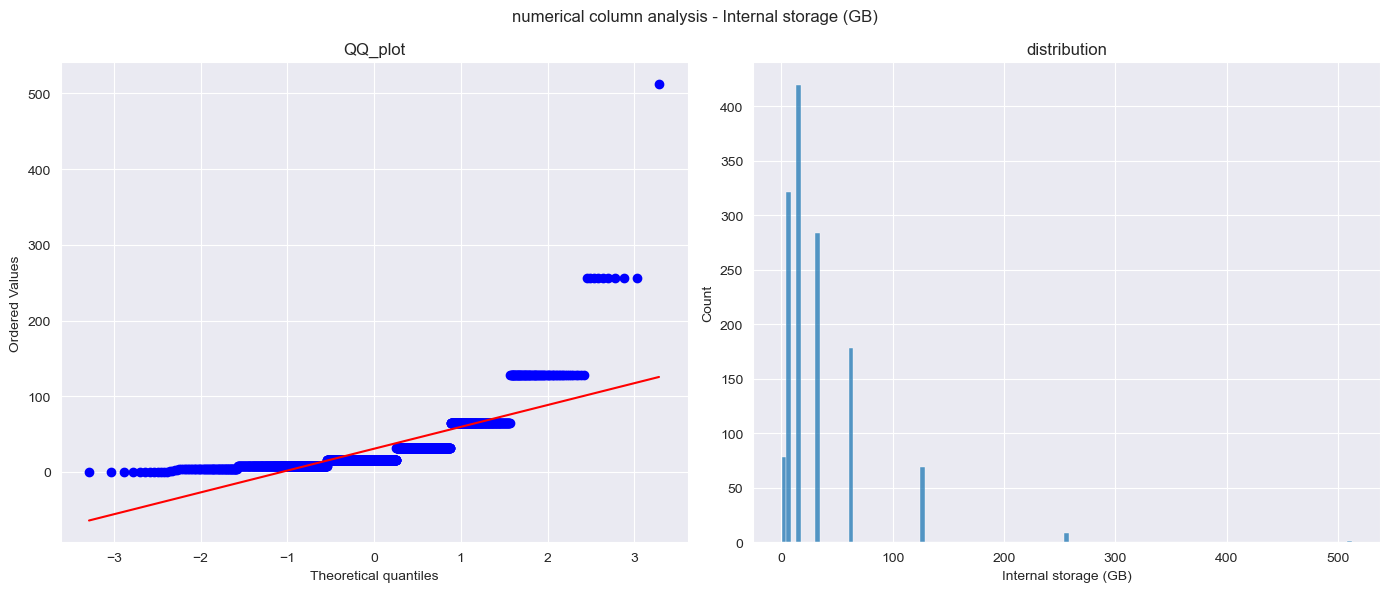

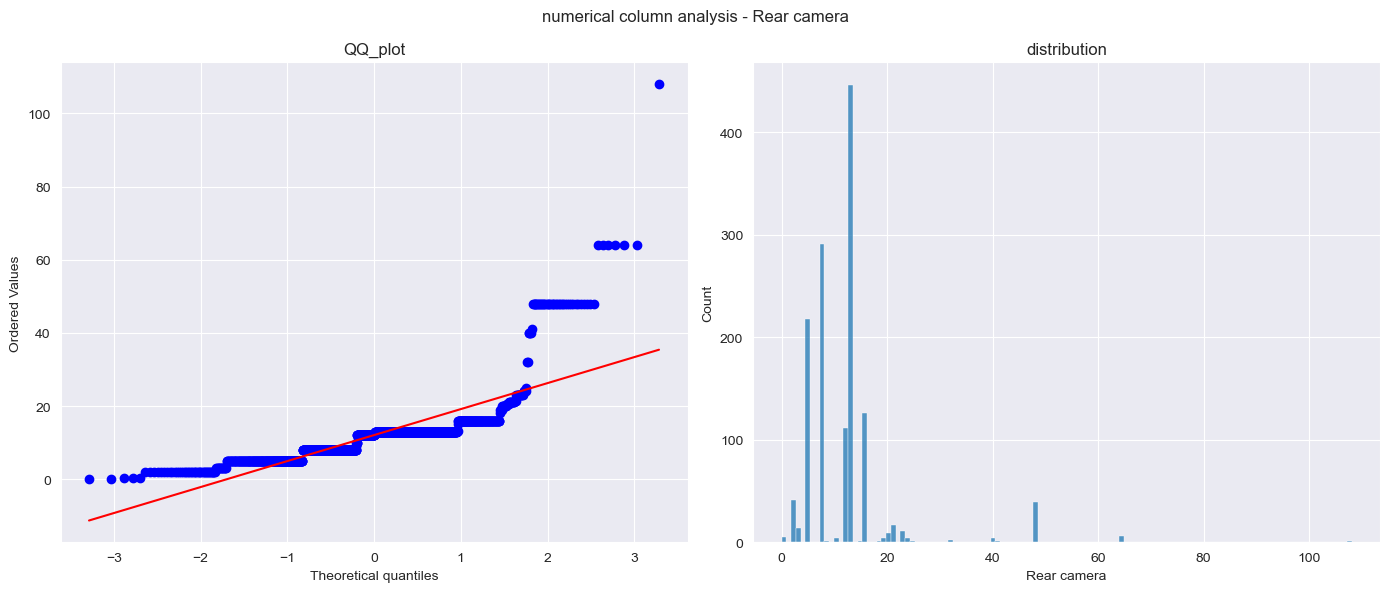

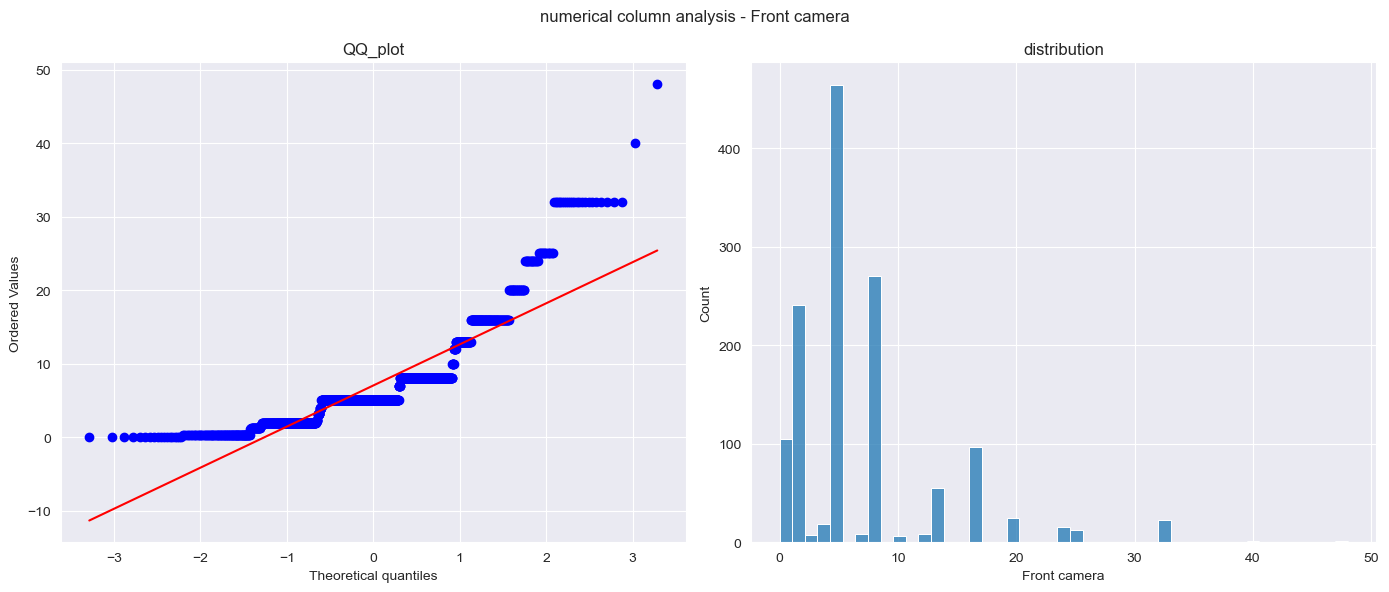

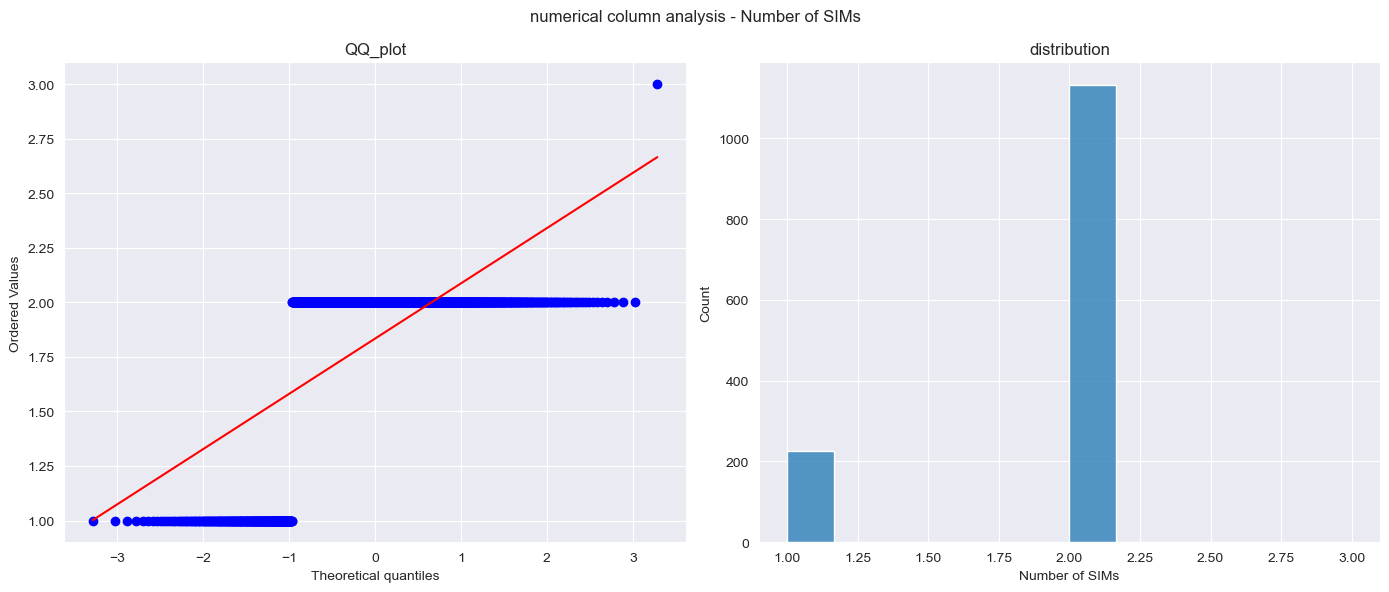

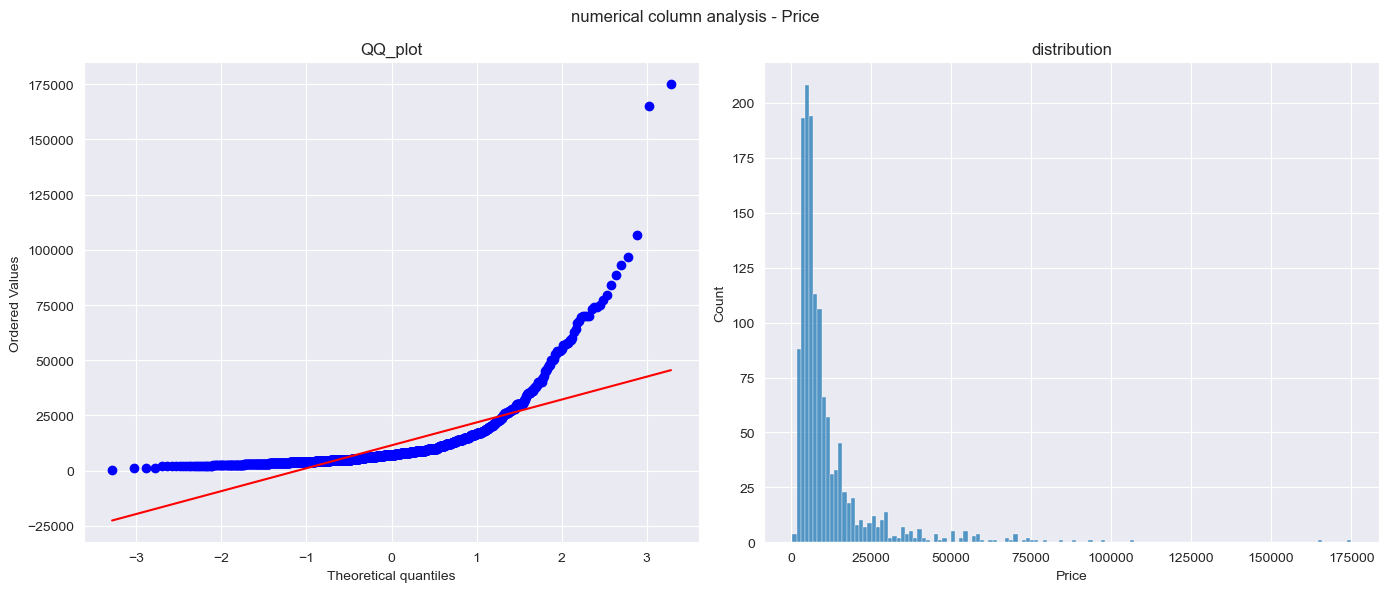

Categorical columns are :['Name', 'Brand', 'Model', 'Touchscreen', 'Operating system', 'Wi-Fi', 'Bluetooth', 'GPS', '3G', '4G/ LTE']
numerical columns are :['Battery capacity (mAh)', 'Screen size (inches)', 'Resolution x', 'Resolution y', 'Processor', 'RAM (MB)', 'Internal storage (GB)', 'Rear camera', 'Front camera', 'Number of SIMs', 'Price']


In [27]:
feature_analyze.numerical_analyze()

In [28]:
feature_analyze.correlation_with_target(numcols,'Price')

Price                     1.000
Internal storage (GB)     0.644
RAM (MB)                  0.613
Resolution y              0.576
Resolution x              0.541
Screen size (inches)      0.402
Rear camera               0.379
Front camera              0.311
Processor                 0.302
Battery capacity (mAh)    0.298
Number of SIMs           -0.162
Name: Price, dtype: float64

In [29]:
feature_analyze.possible_high_correlation(numcols)

{'Front camera',
 'Internal storage (GB)',
 'Price',
 'Processor',
 'RAM (MB)',
 'Rear camera',
 'Resolution y',
 'Screen size (inches)'}

## model_pre processing

In [30]:
class preProcessing:
    def __init__(self, df):
        self.df = df
        
    def outlireHandeling(self, col):
        '''
            function: outlireHandeling -> Performs the log transformation on the columnn
            arg: col (pandas.core.series.Series) -> column of the data set
            return: 'This column does not exsist in data set' (str) -> if the column does not exsist
        '''
        if col not in self.df.columns.tolist():
            return 'This column does not exsist in data set'
        self.df['logTranforedPrice'] = round(np.log10(df[col] + 1),2)
        
    def log_tranformation(self,df):
        
        """
        arg: dataframe(numeric_columns_only)

        function: applying lograthemic transformation on all the numeric columns 

        return: None
        """
        for col in df:
            self.df[col]=self.df[col].map(lambda i: np.log(i) if i>0 else 0)
        
    def comparisionofResults(self, col1, col2):
        '''
            function: comparisionofResults -> shows the visual comaparision of two columns in two bar graph
            arg: col1 (pandas.core.series.Series) -> column of the data set
                 col2 (pandas.core.series.Series) -> column of the data set
            return: None
        '''
        fig, axes = plt.subplots(1, 2, figsize=(14, 4))
        plt.suptitle('Comparision of original price v/s log transformation', fontsize=20)
        sns.histplot(ax=axes[0], x=self.df['Price'], bins=70, kde=True, color=(0.95, 0.1, 0.85))
        axes[0].set_xlabel('Price', fontsize=15)
        axes[0].set_ylabel('Frequency', fontsize=15)
        sns.histplot(ax=axes[1], x=self.df['logTranforedPrice'], bins=50, kde=True, color=(0.2, 0.85, 0.95))
        axes[1].set_xlabel('Log Transformed Price', fontsize=15)
        axes[1].set_ylabel('Frequency', fontsize=15)
        plt.show()
        
    def labelEncoding(self, column):
        '''
            function: labelEncoding -> performs label encoding on the catagorical columns
            arg: column (pandas.core.indexes.base.Index) -> index of the columns 
            return: None
        '''
        labelEncoder = LabelEncoder()
        for col in column:
            self.df[col] = labelEncoder.fit_transform(self.df[col])

In [31]:
preprocess = preProcessing(df)

In [32]:
preprocess.log_tranformation(numcols.drop(columns='Price'))

In [33]:
preprocess.outlireHandeling('Price')

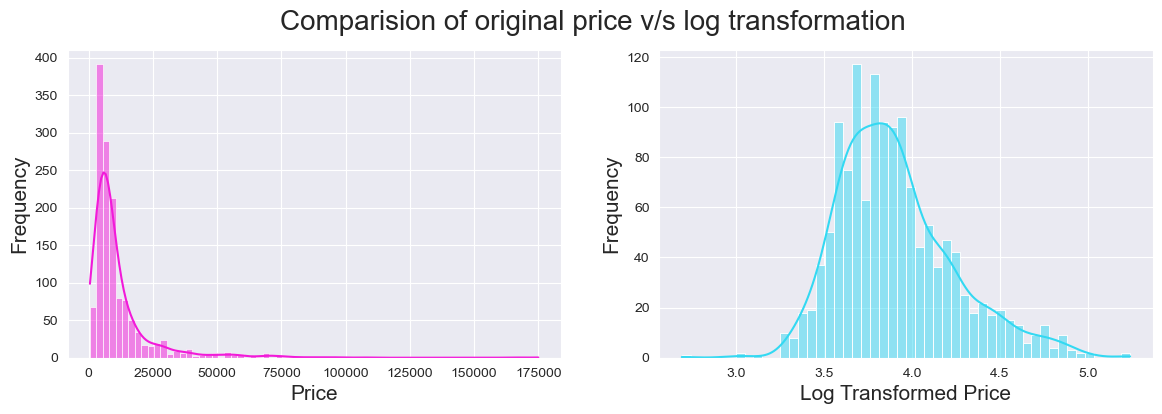

In [34]:
preprocess.comparisionofResults('Price', 'logTranforedPrice')

In [35]:
preprocess.labelEncoding(catCols.drop(columns=['Brand']).columns)

In [36]:
df.head()

Name    Brand  Model  Battery capacity (mAh)  \
0  OnePlus 7T Pro McLaren Edition  OnePlus     49                8.315077   
1                   Realme X2 Pro   Realme   1142                8.294050   
2               iPhone 11 Pro Max    Apple   1288                8.286269   
3                       iPhone 11    Apple   1286                8.042378   
4                    LG G8X ThinQ       LG    522                8.294050   

   Screen size (inches)  Touchscreen  Resolution x  Resolution y  Processor  \
0              1.897620            1      7.272398      8.045588   2.079442   
1              1.871802            1      6.984716      7.783224   2.079442   
2              1.871802            1      7.124478      7.896553   1.791759   
3              1.808289            1      6.719013      7.491088   1.791759   
4              1.856298            1      6.984716      7.757906   2.079442   

   RAM (MB)  ...  Front camera  Operating system  Wi-Fi  Bluetooth  GPS  \
0  9.392662  ...      2.772589                 0      1          1    1   
1  8.699515  ...      2.772589                 0      1          1    1   
2  8.294050  ...      2.484907                 6      1          1    1   
3  8.294050  ...      2.484907                 6      1          1    1   
4  8.699515  ...      3.465736                 0      1          1    1   

   Number of SIMs  3G  4G/ LTE   Price  logTranforedPrice  
0        0.693147   1        1   58998               4.77  
1        0.693147   1        1   27999               4.45  
2        0.693147   1        1  106900               5.03  
3        0.693147   1        1   62900               4.80  
4        0.000000   0        0   49990               4.70  

[5 rows x 22 columns]

## Modelling and testing Pipeline

In [56]:
class training_pipeline:
    def __init__(self,df,target,numeric,categorical,req_1,aplha):

        """
        arg: dataframe
        arg: target --> target variable
        arg: numeric --> numeric columns post_pre_processing and feature selection
        arg: req_1 --> required features for feature engineering
        arg: aplha --> alpha value for the regularizarion techniques

        function: class_constructor

        return: None
        """
        self.df=df
        self.target=target
        self.numeric=numeric
        self.categorical=categorical
        self.combining_features_cat=req_1
        self.alpha=aplha
        self.results = []
        
    def feature_selection(self):
        """
        arg: None

        function: checking the best features present in the dataset using selectKBest 

        return: None
        """
        k = 5  
        selector = SelectKBest(score_func=f_regression, k=k)
        X_selected = selector.fit_transform(self.X, self.y)
        selected_feature_indices = selector.get_support(indices=True)
        self.selected_features = list(self.X.columns[selected_feature_indices])
        print("="*50)
        print(self.selected_features)
        print("="*50)
    def process_module(self):

        """
        arg: None

        function: creating new feature (dimension reduction), process and traiing pipeline

        return: None
        """
        self.df['latest_tech_stack']=self.df[self.combining_features_cat].all(axis=1).astype(int)
        self.column_to_drop_trainig=['Name','Brand','Model','Touchscreen','Resolution y','Wi-Fi','Bluetooth','GPS','3G','4G/ LTE','Price','logTranforedPrice']
        self.X=self.df.drop(columns=self.column_to_drop_trainig)
        self.y=self.df[self.target]
        self.feature_selection()
        numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
        preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, self.numeric)],remainder='passthrough')
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=55)
#         print(type(self.X_train))
        models = {'Linear Regression': LinearRegression(),'Random Forest Regressor': RandomForestRegressor(),'Gradient Boosting Regressor': GradientBoostingRegressor(),
                  'Ridge Regression': Ridge(alpha=self.alpha)}
#         print((self.X_train[:4]))
#         print(type(self.X_train))
        pipeline=Pipeline(steps=[('preprocessor',preprocessor)])
        self.X_train=pipeline.fit_transform(self.X_train)
#         print(self.X_train[:4])
        self.X_test=pipeline.transform(self.X_test)
#         print(self.X_test[:1])
        for model_name,model in models.items():
            self.reg=model
            self.reg.fit(self.X_train,self.y_train)
            self.y_train_pred=self.reg.predict(self.X_train)
            self.y_test_pred=self.reg.predict(self.X_test)
            
            #evaluation
            train_r2=r2_score(self.y_train,self.y_train_pred).round(3)
            test_r2=r2_score(self.y_test,self.y_test_pred).round(3)
            #eval_mse
            train_mse=mean_squared_error(self.y_train,self.y_train_pred).round(3)
            test_mse=mean_squared_error(self.y_test,self.y_test_pred).round(3)
            #eval_mae
            train_mae=mean_absolute_error(self.y_train,self.y_train_pred).round(3)
            test_mae=mean_absolute_error(self.y_test,self.y_test_pred).round(3)
            self.sorted_=self.post_analysis(model_name)
            result={'model':model_name,'mae_train':train_mae,'mae_test':test_mae,'mse_train':train_mse,'mse_test':test_mse,'train_r2':train_r2,'test_r2':test_r2,'feature_seletion':self.selected_features,'feature_importance':self.sorted_}
            self.results.append(result)
            self.vis_prediction(model_name)
            
            
    def vis_prediction(self,model_name):
        """
        arg: name of the model to be plotted

        function: using scatter plot to visulaise the regression model's prediction  

        return: None
        """
        vis_df=pd.DataFrame({'Actual_value':self.y_test,'Prediction':self.y_test_pred})
        fig=px.scatter(vis_df,x='Actual_value',y='Prediction',trendline='ols',title="Performance_{}".format(model_name))
        fig.update_traces(marker=dict(color='blue', size=10))
        fig.update_layout(xaxis=dict(scaleanchor="y",scaleratio=1),yaxis=dict(scaleanchor="x",scaleratio=1))
        fig.show()
        
        
        diff_val=pd.DataFrame({'Difference|Error':(self.y_test-self.y_test_pred)})
        fig2=px.histogram(diff_val,x='Difference|Error',title="Erroe_distribution_in_{}".format(model_name),nbins=25,histnorm='probability density')
        fig2.show()
        
        
        
    def tuning_parameters(self):
        
        """
        arg: None

        function: hyper paramters tuning for the selected models and evaluation of the model resutls 

        return: None
        """
        models={'hp_random_forest':{'base':RandomForestRegressor(),'params':{'n_estimators':[50,75,100],'min_samples_split': [2, 5, 10],'max_depth':[2,6,8]}},
               'hp_boosring':{'base':GradientBoostingRegressor(),'params':{'n_estimators':[50,100,120],'learning_rate': [0.01, 0.05, 0.1],'max_depth':[2,4]}},
               'hp_lasso':{'base':Lasso(),'params':{'alpha':[0.005,.03,.02,.1,.5,10,15,12,25]}}}
        for model_name,model in models.items():
            search=RandomizedSearchCV(model['base'],model['params'],cv=5,n_iter=3,random_state=42,scoring='neg_mean_squared_error')
            search.fit(self.X_train,self.y_train)
            best=search.best_estimator_
            self.reg=best
            self.y_train_pred=self.reg.predict(self.X_train)
            self.y_test_pred=self.reg.predict(self.X_test)
            
            #evaluation
            train_r2=r2_score(self.y_train,self.y_train_pred).round(3)
            test_r2=r2_score(self.y_test,self.y_test_pred).round(3)
            #eval_mse
            train_mse=mean_squared_error(self.y_train,self.y_train_pred).round(3)
            test_mse=mean_squared_error(self.y_test,self.y_test_pred).round(3)
            #eval_mae
            train_mae=mean_absolute_error(self.y_train,self.y_train_pred).round(3)
            test_mae=mean_absolute_error(self.y_test,self.y_test_pred).round(3)
            self.sorted_=self.post_analysis(model_name)
            
            result={'model':model_name,'mae_train':train_mae,'mae_test':test_mae,'mse_train':train_mse,'mse_test':test_mse,'train_r2':train_r2,'test_r2':test_r2,'feature_seletion':self.selected_features,'feature_importance':self.sorted_}
            self.results.append(result)
            self.vis_prediction(model_name)
            
            
    def post_analysis(self,model_name):

        """
        arg: model_name

        function: finding the best feature set used in that particualr model and get the feature importance  

        return: list of top 5 important features identified in that particular model
        """
        if model_name in['hp_lasso','Linear Regression','Ridge Regression']:
            imp=self.reg.coef_
            print("="*50)
            print(self.reg.coef_)
            print("="*50)
        else:
            imp=self.reg.feature_importances_
            print("="*50)
            print(self.reg.feature_importances_)
            print("="*50)
        impo=pd.DataFrame({'feature_imp':imp}, index=self.X.columns)
        sorted_=impo.sort_values(by='feature_imp',ascending=False).head(5)
        print("="*50)
        print(sorted_)
        print("="*50)
        return(sorted_.index.tolist())
        
            
        
    def res_comp(self):

        """
        arg: None

        function: initializing and forming dataframe

        return: Evaluation metrics of the trained models
        """
        
        return pd.DataFrame(self.results)
        

In [38]:
numeric=['Battery capacity (mAh)', 'Screen size (inches)', 'Resolution x','Processor', 'RAM (MB)', 'Internal storage (GB)','Rear camera', 'Front camera', 'Number of SIMs']
req_1=['Touchscreen', 'Wi-Fi', 'Bluetooth', 'GPS', '3G', '4G/ LTE']
categorical=['Operating system','latest_tech_stack']

In [39]:
model_training=training_pipeline(df,'logTranforedPrice',numeric,categorical,req_1,0.5)

In [40]:
model_training.process_module()

['Screen size (inches)', 'Resolution x', 'RAM (MB)', 'Internal storage (GB)', 'Rear camera']
[-0.00752711  0.00379432  0.0980614  -0.01228158  0.06805006  0.08655844
  0.0646392  -0.04580307 -0.02422838  0.06997468 -0.00445728]
                       feature_imp
Resolution x              0.098061
Internal storage (GB)     0.086558
Number of SIMs            0.069975
RAM (MB)                  0.068050
Rear camera               0.064639


[0.0855317  0.07075047 0.38879811 0.01713633 0.05739335 0.1384669
 0.1199177  0.0501595  0.02597798 0.02808621 0.01778174]
                        feature_imp
Resolution x               0.388798
Internal storage (GB)      0.138467
Rear camera                0.119918
Battery capacity (mAh)     0.085532
Screen size (inches)       0.070750


[0.02549355 0.05748023 0.40347871 0.00762385 0.06038851 0.21555076
 0.12567797 0.02744723 0.02681855 0.0411807  0.00885993]
                       feature_imp
Resolution x              0.403479
Internal storage (GB)     0.215551
Rear camera               0.125678
RAM (MB)                  0.060389
Screen size (inches)      0.057480


[-0.0074969   0.00384051  0.09798517 -0.01224427  0.06802842  0.0864571
  0.06457587 -0.04567981 -0.02425631  0.06995006 -0.00440495]
                       feature_imp
Resolution x              0.097985
Internal storage (GB)     0.086457
Number of SIMs            0.069950
RAM (MB)                  0.068028
Rear camera               0.064576


In [41]:
# model_training.vis_prediction()

In [42]:
model_training.res_comp()

model  mae_train  mae_test  mse_train  mse_test  \
0            Linear Regression      0.161     0.153      0.046     0.044   
1      Random Forest Regressor      0.060     0.137      0.007     0.036   
2  Gradient Boosting Regressor      0.119     0.138      0.024     0.036   
3             Ridge Regression      0.161     0.153      0.046     0.044   

   train_r2  test_r2                                   feature_seletion  \
0     0.596    0.566  [Screen size (inches), Resolution x, RAM (MB),...   
1     0.940    0.638  [Screen size (inches), Resolution x, RAM (MB),...   
2     0.783    0.639  [Screen size (inches), Resolution x, RAM (MB),...   
3     0.596    0.566  [Screen size (inches), Resolution x, RAM (MB),...   

                                  feature_importance  
0  [Resolution x, Internal storage (GB), Number o...  
1  [Resolution x, Internal storage (GB), Rear cam...  
2  [Resolution x, Internal storage (GB), Rear cam...  
3  [Resolution x, Internal storage (GB), Number o...

In [43]:
model_training.tuning_parameters()

[0.02476721 0.05113026 0.44706005 0.01195384 0.04524952 0.19561535
 0.13224953 0.02883651 0.02755936 0.02674589 0.0088325 ]
                       feature_imp
Resolution x              0.447060
Internal storage (GB)     0.195615
Rear camera               0.132250
Screen size (inches)      0.051130
RAM (MB)                  0.045250


[0.0051948  0.03716111 0.44001711 0.00046903 0.07689935 0.21266682
 0.14928501 0.00906831 0.01616858 0.05097666 0.00209323]
                       feature_imp
Resolution x              0.440017
Internal storage (GB)     0.212667
Rear camera               0.149285
RAM (MB)                  0.076899
Number of SIMs            0.050977


[ 0.          0.          0.09003228  0.          0.03329687  0.07302402
  0.03473639  0.         -0.00899807  0.04554479  0.        ]
                       feature_imp
Resolution x              0.090032
Internal storage (GB)     0.073024
Number of SIMs            0.045545
Rear camera               0.034736
RAM (MB)                  0.033297


In [44]:
results=model_training.res_comp()

In [55]:
results

mae_train  mae_test  mse_train  mse_test  \
model                                                                   
Linear Regression                0.161     0.153      0.046     0.044   
Random Forest Regressor          0.060     0.137      0.007     0.036   
Gradient Boosting Regressor      0.119     0.138      0.024     0.036   
Ridge Regression                 0.161     0.153      0.046     0.044   
hp_random_forest                 0.120     0.139      0.025     0.036   
hp_boosring                      0.138     0.143      0.033     0.038   
hp_lasso                         0.165     0.158      0.049     0.045   

                             train_r2  test_r2  \
model                                            
Linear Regression               0.596    0.566   
Random Forest Regressor         0.940    0.638   
Gradient Boosting Regressor     0.783    0.639   
Ridge Regression                0.596    0.566   
hp_random_forest                0.781    0.640   
hp_boosring                     0.704    0.618   
hp_lasso                        0.565    0.550   

                                                              feature_seletion  \
model                                                                            
Linear Regression            [Screen size (inches), Resolution x, RAM (MB),...   
Random Forest Regressor      [Screen size (inches), Resolution x, RAM (MB),...   
Gradient Boosting Regressor  [Screen size (inches), Resolution x, RAM (MB),...   
Ridge Regression             [Screen size (inches), Resolution x, RAM (MB),...   
hp_random_forest             [Screen size (inches), Resolution x, RAM (MB),...   
hp_boosring                  [Screen size (inches), Resolution x, RAM (MB),...   
hp_lasso                     [Screen size (inches), Resolution x, RAM (MB),...   

                                                            feature_importance  
model                                                                           
Linear Regression            [Resolution x, Internal storage (GB), Number o...  
Random Forest Regressor      [Resolution x, Internal storage (GB), Rear cam...  
Gradient Boosting Regressor  [Resolution x, Internal storage (GB), Rear cam...  
Ridge Regression             [Resolution x, Internal storage (GB), Number o...  
hp_random_forest             [Resolution x, Internal storage (GB), Rear cam...  
hp_boosring                  [Resolution x, Internal storage (GB), Rear cam...  
hp_lasso                     [Resolution x, Internal storage (GB), Number o...

## Validation and inference 

In [45]:
results.iloc[:,:-2]

model  mae_train  mae_test  mse_train  mse_test  \
0            Linear Regression      0.161     0.153      0.046     0.044   
1      Random Forest Regressor      0.060     0.137      0.007     0.036   
2  Gradient Boosting Regressor      0.119     0.138      0.024     0.036   
3             Ridge Regression      0.161     0.153      0.046     0.044   
4             hp_random_forest      0.120     0.139      0.025     0.036   
5                  hp_boosring      0.138     0.143      0.033     0.038   
6                     hp_lasso      0.165     0.158      0.049     0.045   

   train_r2  test_r2  
0     0.596    0.566  
1     0.940    0.638  
2     0.783    0.639  
3     0.596    0.566  
4     0.781    0.640  
5     0.704    0.618  
6     0.565    0.550

In [57]:
class inference:
    def __init__(self,data):
        """
        arg: data --> dataframe to be visulalised and compared 

        function: class constructor 

        return: None
        """
        self.df=data
       
    def feature_understanding(self):
        """
        arg: None

        function: concatinating the feature importance and feature selection columns to check for the match values
        
        aim :  to verify the feature selection by validating the important features of various model

        return: dataframe consists of model name, feature importance and feature selection before training (reference)
        """
        self.exp1=self.df.iloc[:,0]
        self.exp2=self.df.iloc[:,[-2,-1]]
        return(pd.concat([self.exp1,self.exp2],axis=1))
    
    def general_plot(self,x):
        
        """
        arg: scoring metric to be plotted 

        function: plotting bar graph to check the scoring and evaluation metrics for various models

        return: None
        """
        df=self.df

        if df.index.name!='model':
            df.set_index('model',inplace=True)
        df[x].plot(kind='barh',figsize=(14,7))
        plt.show()
        
    def sort_plot(self,x,y):
        
        """
        arg: x--> train set metrics 
        arg: y --> test set metrics
        

        function: unstacked bar chart to compare the model performance and indentify the overfitting and underfitting cases
    

        return: None
        """
        comp=self.df[[x,y]].plot(kind='bar',stacked=False,figsize=(12,6))
        plt.title('Comprasion of {} vs {}'.format(x,y))
        plt.xlabel('Model')
        plt.xticks(rotation=45, ha='right')

        plt.show()
        
    def plotyy(self,x,y):
        
        """
        arg: x--> train set metrics 
        arg: y --> test set metrics
        

        function: interactive bar graph to closely analyse the results     

        return: None
        """
        unstacked = self.df.reset_index().melt(id_vars='model', value_vars=[x, y], var_name='type', value_name='values')
        fig = px.bar(unstacked, x='model', y='values', color='type', barmode='group', )
        fig.show()

In [47]:
inf_=inference(results)

In [48]:
inf_.feature_understanding()

model  \
0            Linear Regression   
1      Random Forest Regressor   
2  Gradient Boosting Regressor   
3             Ridge Regression   
4             hp_random_forest   
5                  hp_boosring   
6                     hp_lasso   

                                    feature_seletion  \
0  [Screen size (inches), Resolution x, RAM (MB),...   
1  [Screen size (inches), Resolution x, RAM (MB),...   
2  [Screen size (inches), Resolution x, RAM (MB),...   
3  [Screen size (inches), Resolution x, RAM (MB),...   
4  [Screen size (inches), Resolution x, RAM (MB),...   
5  [Screen size (inches), Resolution x, RAM (MB),...   
6  [Screen size (inches), Resolution x, RAM (MB),...   

                                  feature_importance  
0  [Resolution x, Internal storage (GB), Number o...  
1  [Resolution x, Internal storage (GB), Rear cam...  
2  [Resolution x, Internal storage (GB), Rear cam...  
3  [Resolution x, Internal storage (GB), Number o...  
4  [Resolution x, Internal storage (GB), Rear cam...  
5  [Resolution x, Internal storage (GB), Rear cam...  
6  [Resolution x, Internal storage (GB), Number o...

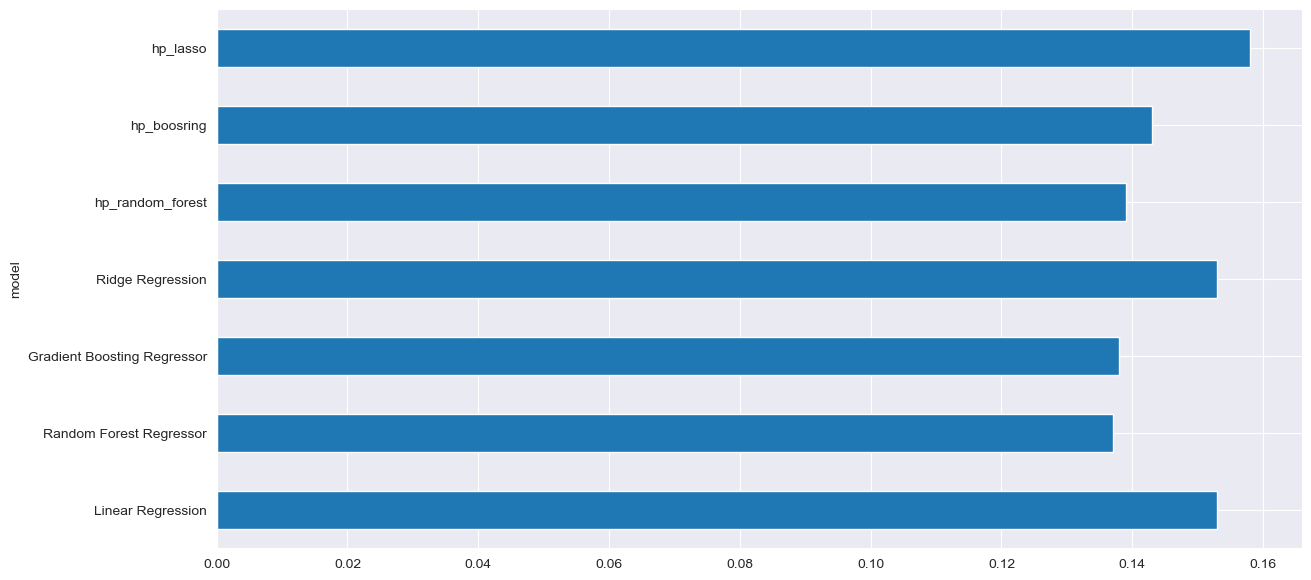

In [49]:
inf_.general_plot('mae_test')

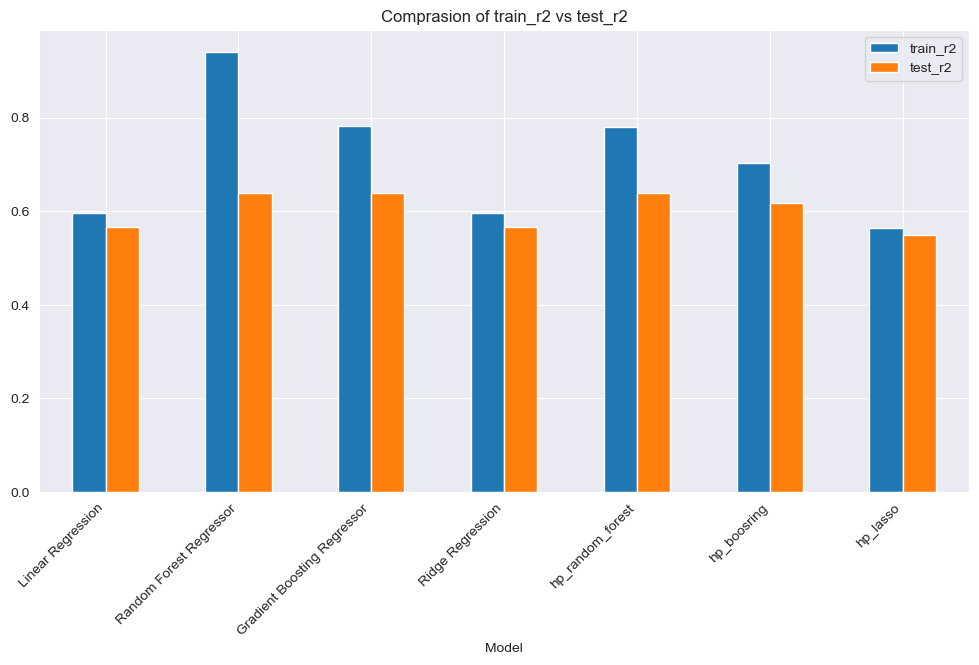

In [50]:
inf_.sort_plot('train_r2','test_r2')

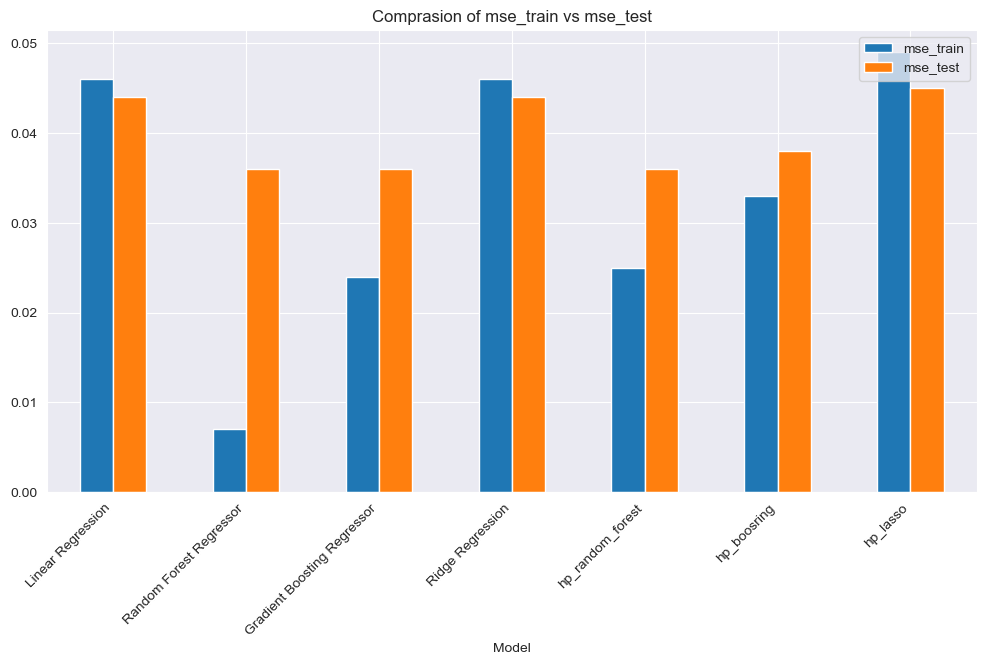

In [51]:
inf_.sort_plot('mse_train','mse_test')

In [52]:
inf_.plotyy('train_r2','test_r2')

In [53]:
inf_.plotyy('mse_train','mse_test')